# Non-normality

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

logging.basicConfig(level=logging.CRITICAL)

from lightgbm.sklearn import LGBMRegressor
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.estimators import MLPRegressor, MultiOutputRegressor, RidgeCV
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

## Non-normality

At the stock-level, non-normality (e.g. skewness or kurtosis) may not be a significant problem:

- the portfolio might be short a stock with negative skewness

- part of the stock kurtosis might diversify away at the portfolio level.

But factor-level non-normality is harder to diversify – especially the returns of strategy based on risk-premia (which are generally non-normally distributed):

- by definition, in risk-off environments, these strategies do not pay off and the left tails of the return distribution can be very “thick" leading to “rare disasters"

In this section, we discuss how to document non-normality:

- use some test statistics that involve skewness and kurtosis. 

- illustrate some methods using industry momentum.

The statistics of higher moments: 

-  $skewness =  \frac{E[(x - \bar{x})^3]}{\sigma_x^3}$ 

-  $kurtosis = \frac{E[(x - \bar{x})^4]}{\sigma_x^4}$

- Jarque-Bera statistics $JB = \frac{T}{6} \left(skewness^2 + \frac{(kurtosis-3)^2}{4} \right)$ 

- If the observations $\{x_1,..,x_T\}$ are independant and follow a Normal distribution, then 

    1. $skewness=0$ 

    1. $kurtosis=3$ 

    1. $JB$ follows of Chi-squared distribution with two degrees of freedom. 

- The third assertion provides a way to test whether a variable is Normally distributed. 

In [2]:
from scipy.stats import jarque_bera, kurtosis, skew

**Normally distributed random data**:

- we can _not_ reject the null hypothesis that the data follows is a Normal distribution! 

In [3]:
(T, N) = ret.shape

In [4]:
x = np.random.normal(0, 1, T)  # create random values based on a normal distribution

print(f"Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}")
print(f"Skewness of normal distribution (should be 0): {skew(x):.3f}")
print(f"Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}")

Excess kurtosis of normal distribution (should be 0): -0.111
Skewness of normal distribution (should be 0): 0.011
Jarque beta of normal distribution (should be 0): 0.469


With `fisher=False`, the function `kurtosis` computes the raw kurtosis (the default is `fisher=True`). 

In [5]:
kurtosis(np.random.normal(0, 1, T), fisher=False)

3.00969388208472

**Uniformly distributed random data**: 

- we can reject at any confidence level the null hypothesis that the data follows a Normal distribution! 

In [6]:
x = np.random.uniform(0, 1, T)  # create random values based on a normal distribution

print(f"Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}")
print(f"Skewness of normal distribution (should be 0): {skew(x):.3f}")
print(f"Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}")

Excess kurtosis of normal distribution (should be 0): -1.185
Skewness of normal distribution (should be 0): 0.042
Jarque beta of normal distribution (should be 0): 51.904


**Industry momentum data**: 

- we can also reject the null hypothesis of a Normal distribution 

In [7]:
pnl = (
    Backtester(MeanVariance()).compute_holdings(features, target).compute_pnl(ret).pnl_
)

In [8]:
x = pnl

print(f"Excess kurtosis of normal distribution (should be 0): {kurtosis(x):.3f}")
print(f"Skewness of normal distribution (should be 0): {skew(x):.3f}")
print(f"Jarque beta of normal distribution (should be 0): {jarque_bera(x)[0]:.3f}")

Excess kurtosis of normal distribution (should be 0): 1.860
Skewness of normal distribution (should be 0): 0.049
Jarque beta of normal distribution (should be 0): 95.382


Pnl std=2.10


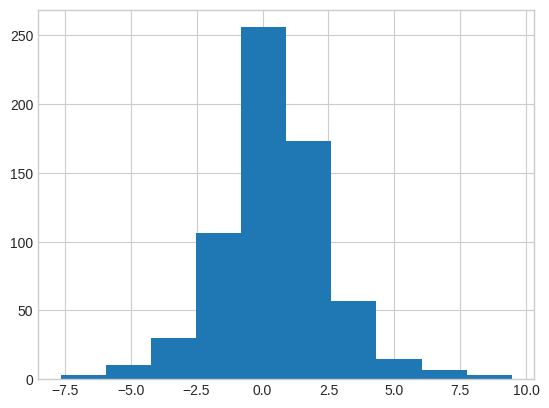

In [9]:
print(f"Pnl std={pnl.std():.2f}")
pnl.hist();

 The test in the notebook shows that the normality assumption is easily rejected for the momentum strategy return – there are a lot of observations (T large) and significant deviations.

## The statistics of rolling sharpe ratio

We now focus on 3-year rolling sharpe ratio:

- A 3-year horizon is the natural horizon to evaluate the performance of investment strategies.

- Significant underperformance over 3 years is almost always a show-stopper!

- In particular, we assess the impact of skewness and kurtosis on the rolling sharpe ratio.

**Lemma** [Lo, 1996]. When the underlying data is iid Normally distributed, the limiting distribution of the estimated  monthly sharpe ratio $\hat{S}$ (relative to the true unobserved $S$) is 
$$
\sqrt{T} (\hat{S} - S) \rightarrow N\left(0, 1 + \frac{S^2}{2}\right) 
$$
*Proof*. For independently Normally distributed returns, we have
$$
\sqrt{T} \left[ \begin {array}{c} \hat{\mu} - \mu \\ \hat{\sigma}^2- \sigma^2  \end {array} \right] \rightarrow N \left( \left[ \begin {array}{c} 0 \\ 0 \end {array} \right];  \left[ \begin {array}{cc} \sigma^2 & 0 \\ 0 & 2 \sigma^4  \end {array} \right]  \right)
$$
For $S = g(\mu,\sigma^2) = \frac{\mu}{\sqrt{\sigma^2}}$, the asymptotic variance of $\hat{S}$ is 
$$
 \left[ \begin {array}{c} \frac{\partial g}{\partial \mu} \\ \frac{\partial g}{\partial (\sigma^2)} \end {array} \right]^T \left[ \begin {array}{cc} \sigma^2 &  0 \\ 0 & 2 \sigma^4  \end {array} \right]  \left[ \begin {array}{c} \frac{\partial g}{\partial \mu} \\ \frac{\partial g}{\partial (\sigma^2)} \end {array} \right]  = \frac{1}{\sigma^2} \sigma^2 +   \left(- \frac{\mu}{2\sigma^3}\right)^2 (2 \sigma^4)
$$

**Corollary.** The minimum monthly $S_0$ for a monthly strategy where the Sharpe ratio is always statistically different from 0 at the 5\%-confidence level over a window of $T$ months is given by 

$$S_0 - 1.96 \sqrt{\frac{1+\frac{S_0^2}{2}}{T}} =0  \Leftrightarrow  S_0 = \sqrt{\frac{1}{\frac{T}{1.96^2}-1/2}} $$

- Rule of thumb: for a 36-month horizon, then the monthly $S_0 \approx 0.35$ or after annualization 

$$ S_0^{\text {annualized}} \approx .35 \times  \sqrt{12} = 1.16 
$$

When the returns are not Normally distributed ($skewness \neq 0$ and (excess) $kurtosis\neq 0$), the Central Limit theorem still ensures the asymptotic normality. (In what follows, `kurtosis` refers to the "excess kurtosis.)


**Lemma** [Mertens, 2002] The asymptotic distribution of $\hat{S}$ is  

$$
\sqrt{T} (\hat{S} - S) \rightarrow N\left(0, V_{\infty} \right) 
$$
where $V_{\infty} = 1 + \frac{S^2}{2} - skewness \times S + \frac{kurtosis \times S^2}{4}$.

*Proof.* The asymptotic variance of $\left[\begin {array}{c} \hat{\mu} - \mu \\ \hat{\sigma}^2 - \sigma^2 \end {array} \right]$ is: 
$$
E\left[\begin {array}{cc} (r_t - \mu)^2 & (r_t - \mu)[(r_t - \mu)^2 - \sigma^2]\\ (r_t - \mu)[(r_t - \mu)^2 - \sigma^2] & [(r_t - \mu)^2 - \sigma^2]^2 \end {array} \right]\\
= \left[ \begin {array}{cc} \sigma^2 & E[(r_t - \mu)^3] \\ E[(r_t - \mu)^3] & 2 E[(r_t - \mu)^4] - \sigma^4  \end {array} \right]
$$

**Corollary.** The minimum $S_0(skewness, kurtosis)$ for a monthly strategy where the information is always statistically different from 0 at the 5%-confidence level over a window of $T$ months is increasing in *kurtosis* and decreasing in *skewness*. 

*Proof.* The function $f(S,skewness,kurtosis)$ 
$$
= S - 1.96 \sqrt{\frac{ 1 + \frac{S^2}{2} - skewness \times S + \frac{kurtosis \times S^2}{4}}{T}  }
$$
is increasing in $S$ and *skewness* and decreasing in *kurtosis*, so that $S_0$ defined by $f(S_0,skewness,kurtosis)=0$ is decreasing in *skewness* and increasing in *kurtosis*.

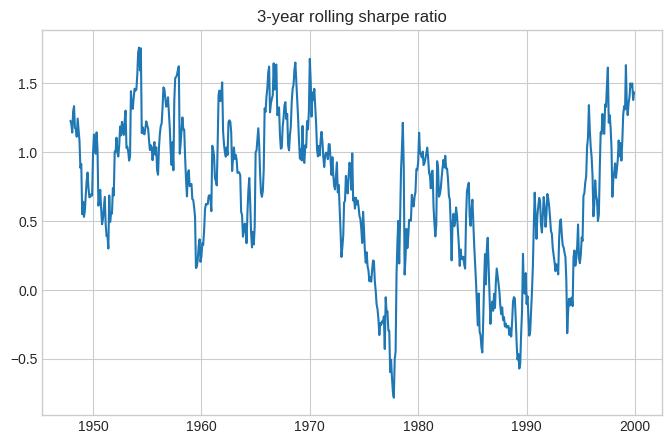

In [10]:
sr3y = pnl.rolling(36).apply(sharpe_ratio)
line(sr3y, legend=False, title="3-year rolling sharpe ratio", start_date="1945")

Below we compute the two lower bounds for the sharpe ratio.

In [11]:
sr3y_lb = sr3y - 1.96 * np.sqrt((1 + 0.5 * sr3y**2) / 36) * np.sqrt(12)
skew3y = pnl.rolling(36).apply(skew)
kurtosis3y = pnl.rolling(36).apply(kurtosis)
sr3y_lb_bis = sr3y - 1.96 * np.sqrt(
    (1 + 0.5 * sr3y**2 - skew3y * sr3y + 0.25 * kurtosis3y * sr3y**2) / 36
) * np.sqrt(12)

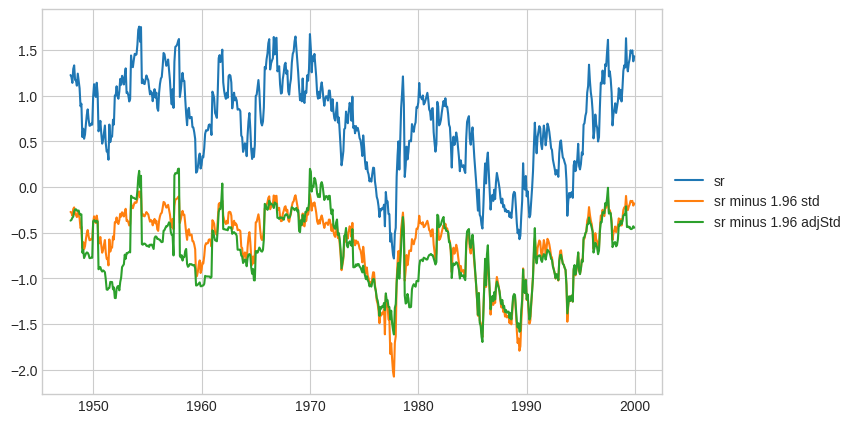

In [12]:
line(
    {"sr": sr3y, "sr minus 1.96 std": sr3y_lb, "sr minus 1.96 adjStd": sr3y_lb_bis},
    start_date="1945",
)

Even generic momentum strategies (including industry momentum) have a fairly strong Sharpe ratio... 

-  ... but the performance includes kurtosis/skewness risk premia, with occasional deep underperformance over a 3-year horizon. 